In [1]:
import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import urllib.request
from scipy.stats import spearmanr,pearsonr
import matplotlib.pyplot as plt
import cv2
import scipy
from skimage.measure import regionprops,label,regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.exposure import equalize_adapthist

from skimage.morphology import disk  # noqa
from scipy.spatial.distance import cdist

In [2]:
videoname='visual_avoidance_test_26'

In [3]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

In [4]:
a=240
b=241
r=218

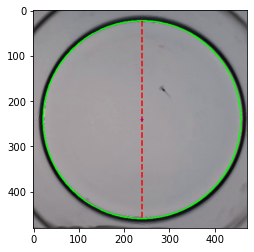

In [5]:
cv2.circle(image, (a, b), r, (0, 255, 0), 2)
cv2.circle(image, (a, b), 1, (0, 0, 255), 3)
plt.imshow(image)
plt.plot((a,a),(b-r,b+r),linestyle='--',c='r')


get location of first spot

In [6]:
# Convert to grayscale.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))

        
#binarize
thresh = threshold_otsu(gray_blurred)
binary = gray_blurred >= thresh

In [13]:
tadpole_location=[]
tadpole_location.append([240,240])

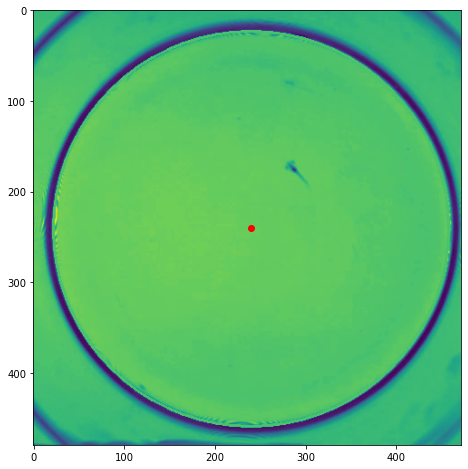

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(gray)
plt.scatter(tadpole_location[len(tadpole_location)-1][1],tadpole_location[len(tadpole_location)-1][0],c='r')


In [15]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

thresh = threshold_otsu(gray)
binary = gray >= thresh


In [16]:
# Convert to grayscale.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3,3))
        
#binarize
thresh = threshold_otsu(gray_blurred)
binary_before = gray_blurred >= thresh


labeled_before, nr_objects__before = scipy.ndimage.label(binary_before ==0) 
#     print("Number of objects is {}".format(nr_objects))

info_table_before = pd.DataFrame(
    regionprops_table(
        labeled_before,         properties=('label', 'area'),
    )
).set_index('label') 

for indi,i in enumerate(info_table_before['area']):
    if i<100:
        labeled_before[labeled_before==info_table_before.index[indi]]=0

In [17]:

labeled_before[labeled_before>0]=1
# if videoname=='edge preference_control':
#     labeled_before = dilation(labeled_before, selem=disk(1))
    
    
labeled_before=~labeled_before



labeled_before[labeled_before==-2]=False
labeled_before[labeled_before==-1]=True

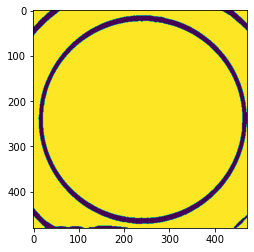

In [18]:
plt.imshow(labeled_before)

In [277]:
# initial
tadpole_location=[]
tadpole_location.append([240,240])
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()
count = 0
switch_or_not=1


In [322]:
# %%time
binary_before=labeled_before
while success:
    success,image = vidcap.read()
    count += 1

#     if count==710:
#         tadpole_location.append([36,250])    

        
    if count==91:
        tadpole_location.append([260,35])
        continue

    interval=20
#     if (count>420 and count<500) :
#         interval=10
#     elif count==143 or (count>=188 and count<=260) or (count>=604 and count<=711) :
#         interval=20
#     else:
#         interval=35

    if not success:
        break
        
    previous_tadpole_loc=tadpole_location[len(tadpole_location)-1]

    # Convert to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur using 3 * 3 kernel.
    gray_blurred = gray     
    if (count>=94 and count<=97) or (count>=244 and count<=255)  or (count>=385 and count<=400) or (count>=640 and count<=670):
        gray_blurred = equalize_adapthist(gray,kernel_size=5)

    thresh = threshold_otsu(gray_blurred)
    binary = gray_blurred >= thresh
    if (count >=435 and count <=795) or (count >=673 and count <=880):
        binary[binary==binary_before]=1    
        
    tadpole_loc_img=binary[max(int(previous_tadpole_loc[0])-interval,0):int(previous_tadpole_loc[0])+interval,
                          max(0,int(previous_tadpole_loc[1])-interval):int(previous_tadpole_loc[1])+interval]
    labeled, nr_objects = scipy.ndimage.label(tadpole_loc_img ==0) 

    info_table = pd.DataFrame(
        regionprops_table(
            labeled,         properties=('label', 'centroid','area','eccentricity'),
        )
    ).set_index('label') 
    
    if info_table.shape[0]==0:
        dapi_coord = np.argwhere(labeled>0)
        if dapi_coord.shape[0]>0:

            relative_loc=dapi_coord[np.argmin(cdist(dapi_coord,np.array([interval,interval]).reshape(1,-1))),:]
            tadpole_location.append([int(previous_tadpole_loc[0])-interval+relative_loc[0],
                                    int(previous_tadpole_loc[1])-interval+relative_loc[1]])
        else:
            tadpole_location.append([int(previous_tadpole_loc[0]),
                                    int(previous_tadpole_loc[1])])
#     elif (count >=435 and count <=450):
        
#         relative_loc = [info_table.iloc[np.argmax(info_table['area'])]['centroid-0'],
#                             info_table.iloc[np.argmax(info_table['area'])]['centroid-1']]
#         tadpole_location.append([int(previous_tadpole_loc[0])-interval+relative_loc[0],
#                             int(previous_tadpole_loc[1])-interval+relative_loc[1]])
        
    else:
#         if (count >=435 and count <=450):
#             relative_loc = [info_table.iloc[np.argmax(info_table['eccentricity'])]['centroid-0'],
#                             info_table.iloc[np.argmax(info_table['eccentricity'])]['centroid-1']]
#         else:
            
        info_table=info_table.drop('area',axis=1)
        info_table=info_table.drop('eccentricity',axis=1)

        if np.min(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1)))>20:
            print(f'error at {count}!')

            print("min dist is {}".format(np.min(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1)))))

        relative_loc = np.array(info_table)[np.argmin(cdist(np.array(info_table),np.array([interval,interval]).reshape(1,-1))),:]



        tadpole_location.append([int(previous_tadpole_loc[0])-interval+relative_loc[0],
                            int(previous_tadpole_loc[1])-interval+relative_loc[1]])
    if count ==822:
        break

In [323]:
count

801

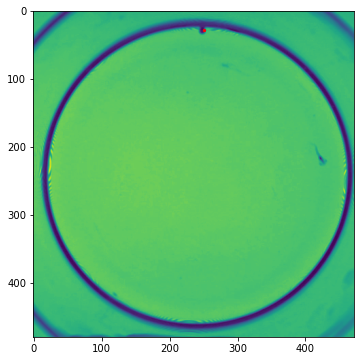

In [325]:
plt.figure(figsize=(6,6))
plt.imshow(gray)
plt.scatter(tadpole_location[len(tadpole_location)-1][1],tadpole_location[len(tadpole_location)-1][0],c='r',s=5)

###### plt.imshow(tadpole_loc_img)

In [326]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()

Text(0.5, 1.0, 'visual_avoidance_test_26')

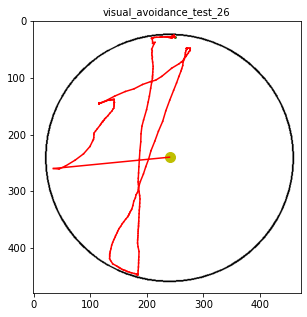

In [327]:
vidcap = cv2.VideoCapture(videoname+'.mp4')
success,image = vidcap.read()
tadpole_location_smooth=tadpole_location
plt.figure(figsize=(5,5))

# image_b=np.zeros(image.shape)+255
image[:]=255
cv2.circle(image, (a, b), r, (0, 0, 0), 2)
plt.imshow(image)
##line plot
for i in range(0, len(tadpole_location_smooth)):
    plt.plot(np.array(tadpole_location_smooth)[i:i+2,1],np.array(tadpole_location_smooth)[i:i+2,0],c='r')

###dot plot
# plt.scatter(np.array(tadpole_location_smooth)[:,1],np.array(tadpole_location_smooth)[:,0],s=3,c='r')
# plt.scatter(np.array(tadpole_location)[:,1],np.array(tadpole_location)[:,0],s=10,c='r')
plt.scatter(tadpole_location[0][1],tadpole_location[0][0],c='y',s=100)
plt.scatter(tadpole_location[len(tadpole_location)-1][1],tadpole_location[len(tadpole_location)-1][0],c='g',s=3)
# plt.axis('off')
plt.title(videoname,fontsize=10)

In [328]:
tadpole_location_smooth=pd.DataFrame(tadpole_location_smooth)

In [329]:
tadpole_location_smooth.to_csv('visual_avoidance_test_round.csv')